In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expressions and string processing
import re
import string

# ==== NLP Libraries ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Machine Learning Libraries ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download essential NLTK resources (run once, comment out after first run)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set up plot aesthetics for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Loading the dataset**

In [3]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["test"])

In [4]:
!pip install nlpaug

d: index of the example

verse_text: The text of the poem verse

label: The sentiment label.
Here

0 = negative

1 = positive

2 = no impact

3 = mixed (both negative and positive)


Note: The original dataset uses different label indices (negative = -1, no impact = 0, positive = 1)

In [5]:

# Display basic information
print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)
print("Validation data shape:", df_validation.shape)

# Preview the first few rows of the training data
print("\nFirst 5 rows of training data:")
display(df_train.head(10))

Training data shape: (892, 3)
Test data shape: (104, 3)
Validation data shape: (105, 3)

First 5 rows of training data:


,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3
5,5,the red sword sealed their vows!,3
6,6,and very venus of a pipe.,2
7,7,"who the man, who, called a brother.",2
8,8,"and so on. then a worthless gaud or two,",0
9,9,to hide the orb of truth--and every throne,2


In [6]:
# Check for missing values
print("\nMissing values in training data:")
print(df_train.isnull().sum())


print("\nMissing values in validation data:")
print(df_validation.isnull().sum())

print("\nMissing values in test data:")
print(df_test.isnull().sum())


Missing values in training data:
id            0
verse_text    0
label         0
dtype: int64

Missing values in validation data:
id            0
verse_text    0
label         0
dtype: int64

Missing values in test data:
id            0
verse_text    0
label         0
dtype: int64


In [7]:
#Sentiment distribution in training data

sentimientos={
    0: 'negative',
    1: 'positive',
    2: 'no impact',
    3: 'mixed'
}

df_train['sentiment']=df_train['label'].map(sentimientos)
df_test['sentiment']=df_test['label'].map(sentimientos)
df_validation['sentiment']=df_validation['label'].map(sentimientos)
df_train['sentiment'].value_counts()


sentiment
no impact    555
negative     155
positive     133
mixed         49
Name: count, dtype: int64

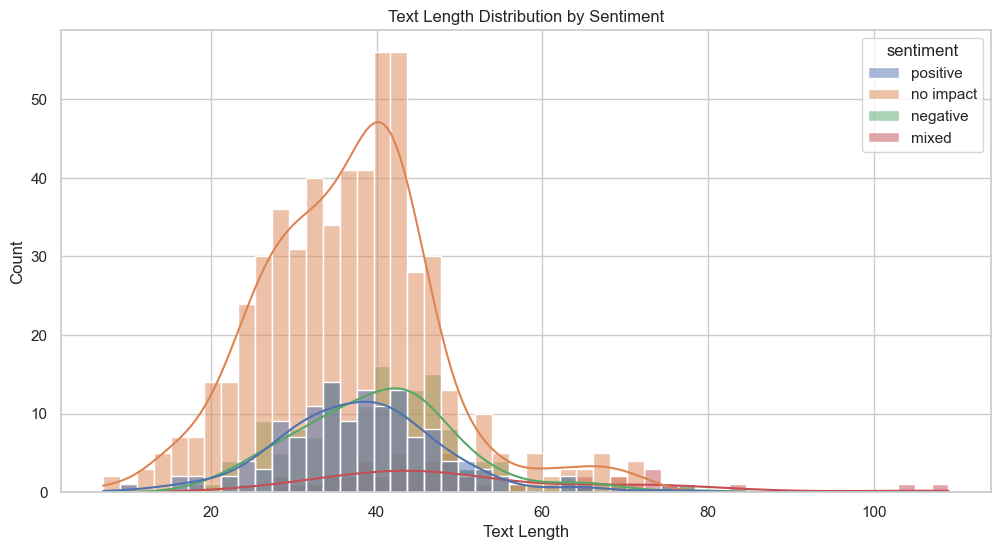

Percentile 95:  60.0
Percentile 99:  73.0


In [8]:
# Explore text length distribution
df_train['len_text'] = df_train['verse_text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_train, x='len_text', hue='sentiment', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.show()

print("Percentile 95: ",np.percentile(df_train['len_text'], 95))
print("Percentile 99: ",np.percentile(df_train['len_text'], 99))

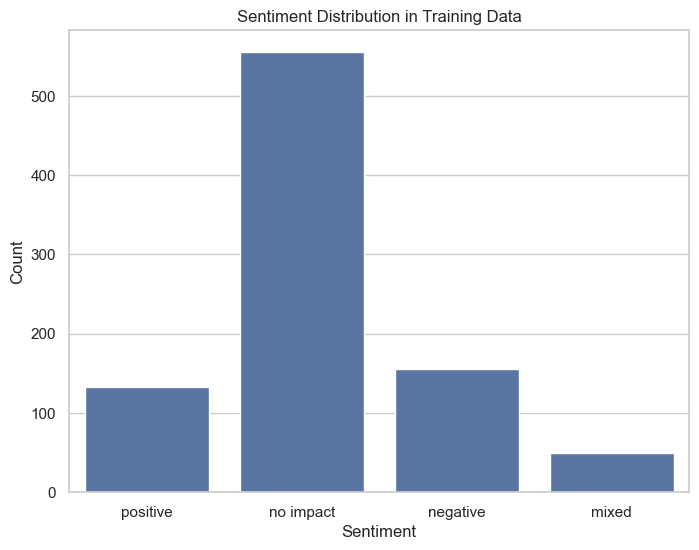

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
#Visualize sentiment distribution

plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='sentiment')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [11]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
# Clean and preprocess text before modeling to remove noise and standardize the input.
# This pipeline covers: lowercasing, removing URLs, HTML, mentions, hashtags, punctuation, numbers, and extra whitespace.
# Tokenization, stopword removal, and lemmatization are also included for robust NLP.

def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text after #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize.

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

In [13]:
# Set of stop_words
stop_words = set(stopwords.words('english'))
print(stop_words)

{'itself', 'we', 'had', 'does', "should've", 'above', 'no', 'your', 'when', 'further', 'once', 'being', "she'd", "doesn't", 'to', 'isn', "hasn't", "we'd", "we're", 'those', 'below', 'our', 're', "we'll", "i'll", 'too', 'up', "it'd", 'in', 'off', "you're", "haven't", 'so', 'o', 'more', 'into', "wouldn't", "it'll", 'am', 'any', 'can', 'her', 'mustn', 'very', "she's", 'weren', "they'd", 'hasn', 'than', 'until', 'you', 'now', 'how', 'that', 'wasn', 'then', 'should', "that'll", 'not', 'where', 'herself', 'hers', 'own', 'couldn', 'yourself', 'll', 'each', 'an', 'few', 'here', 'his', "i'm", 'from', 'the', 'having', 'most', 'while', 'against', 'been', 'of', 'be', 'and', 'my', 'their', 'are', 'only', 'don', 'through', 'wouldn', 'same', 'were', "didn't", 'yours', 'me', "it's", 'just', "wasn't", 'there', 'won', 'down', 'didn', 'them', "shouldn't", "i'd", 'during', 'doesn', 'about', 'at', 'they', 'aren', 'doing', 'is', 'was', 'do', 'these', 'has', 'shouldn', 'again', "i've", 'which', 'mightn', 'ou

In [14]:
#apply preprocessing function to train,validation and test data
df_train['processed_text'] = df_train['verse_text'].apply(preprocess_text)
df_validation['processed_text'] = df_validation['verse_text'].apply(preprocess_text)
df_test['processed_text'] = df_test['verse_text'].apply(preprocess_text)

#Original vs preprocessed text
for i in range(3):
  print(f"Original Text: {df_train['verse_text'][i]}")
  print(f"Processed Text: {df_train['processed_text'][i]}")

Original Text: with pale blue berries. in these peaceful shades--
Processed Text: pale blue berry peaceful shade
Original Text: it flows so long as falls the rain,
Processed Text: flow long fall rain
Original Text: and that is why, the lonesome day,
Processed Text: lonesome day


In [15]:
  import nltk
  nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [16]:
# Applying random augmentations with increased minority class augmentation

import nlpaug.augmenter.word as naw
import random
import numpy as np
import nlpaug

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


#Minority classes
minority_classes=["negative","positive","mixed"]

print("Original distribution: ", df_train['sentiment'].value_counts())

label_col="sentiment"
text_col="processed_text"



aug= naw.SynonymAug(aug_src='wordnet')
augmented_data = []

for label in df_train[label_col].unique():
  subset=df_train[df_train[label_col]==label]

  #Augment 5 times majority classes
  if label not in minority_classes:
    for _,row in subset.iterrows():
      for i in range(4):
        augmented_text=aug.augment(row[text_col])
        print("Original text: ", row[text_col])
        if augmented_text:
          stru=augmented_text[0]
        else:
          stru=row[text_col]
        print("Augmented text: ", stru)
        augmented_data.append({text_col:stru,label_col:label})
  #Augment 30 times minority classes (increased from 14):
  else:
    for _,row in subset.iterrows():
      for i in range(30):
        augmented_text=aug.augment(row[text_col])
        print("Original:", row[text_col])
        if augmented_text:
          stru=augmented_text[0]
        else:
          stru=row[text_col]
        print("Augmented text: ",stru)
        augmented_data.append({text_col:stru,label_col:label})


df_augmented=pd.concat([df_train,pd.DataFrame(augmented_data)],ignore_index=True)
print("New distribution:", df_augmented[label_col].value_counts())

df_augmented.to_csv("augmented_data.csv",index=False)


Original distribution:  sentiment
no impact    555
negative     155
positive     133
mixed         49
Name: count, dtype: int64
Original: pale blue berry peaceful shade
Augmented text:  wan blue berry peaceful tone
Original: pale blue berry peaceful shade
Augmented text:  pale blue air berry peaceful spook
Original: pale blue berry peaceful shade
Augmented text:  pallid blue berry peaceful nicety
Original: pale blue berry peaceful shade
Augmented text:  wan blue berry peaceful tincture
Original: pale blue berry peaceful shade
Augmented text:  pallid blue devil berry peaceful shade
Original: pale blue berry peaceful shade
Augmented text:  pale blue berry passive tincture
Original: pale blue berry peaceful shade
Augmented text:  pale blue chuck berry peaceful wraith
Original: pale blue berry peaceful shade
Augmented text:  pale blueing berry peaceable shade
Original: pale blue berry peaceful shade
Augmented text:  pale blueing berry peaceful shadowiness
Original: pale blue berry peaceful

In [17]:
df_augmented=df_augmented.drop(columns=['id','verse_text','label'])
df_augmented.head()

labels={
     "negative":0,
    "positive":1,
    "no impact":2,
    "mixed":3
}

df_augmented['label']=df_augmented['sentiment'].map(labels)
df_augmented.head()


,sentiment,len_text,processed_text,label
0,positive,50.0,pale blue berry peaceful shade,1
1,no impact,35.0,flow long fall rain,2
2,negative,34.0,lonesome day,0
3,mixed,109.0,peruse conquered fame hero victory mighty gene...,3
4,mixed,39.0,inward strife truth liberty,3


In [18]:
df_test=df_test.dropna(subset=['verse_text','sentiment'])

In [17]:
df_test

,id,verse_text,label,sentiment,processed_text
0,0,"my canoe to make more steady,",2,no impact,canoe make steady
1,1,and be glad in the summer morning when the kin...,1,positive,glad summer morning kindred ride way
2,2,and when they reached the strait symplegades,2,no impact,reached strait symplegades
3,3,she sought for flowers,2,no impact,sought flower
4,4,"if they are hungry, paradise",2,no impact,hungry paradise
...,...,...,...,...,...
99,99,shall live my highland mary.,2,no impact,shall live highland mary
100,100,now is past since last we met,2,no impact,past since last met
101,101,begins to live,2,no impact,begin live
102,102,beneath the hazel bough;,2,no impact,beneath hazel bough


In [19]:

# Count Vectorizer configuration
CountVect=CountVectorizer(max_features=10000,ngram_range=(1,2))
X_train_cv=CountVect.fit_transform(df_augmented['processed_text'])

X_test_cv=CountVect.transform(df_test['processed_text'])
X_val_cv=CountVect.transform(df_validation['processed_text'])
y_train=df_augmented['label']
y_test=df_test['label']
y_val=df_validation['label']

print("After countvectorizer X_train: ", X_train_cv.shape)
print("After countvectorizer X_test: ", X_test_cv.shape)
print("After countvectorizer X_val: ", X_val_cv.shape)

print("X_train: ", X_train_cv)
print("y_train: ", y_train)



After countvectorizer X_train:  (13222, 10000)
After countvectorizer X_test:  (104, 10000)
After countvectorizer X_val:  (105, 10000)
X_train:    (0, 5987)	1
  (0, 978)	1
  (0, 821)	1
  (0, 6095)	1
  (0, 7559)	1
  (0, 5988)	1
  (0, 979)	1
  (0, 824)	1
  (0, 6097)	1
  (1, 3078)	1
  (1, 4588)	1
  (1, 2758)	1
  (1, 6709)	1
  (1, 3082)	1
  (1, 4593)	1
  (2, 4582)	1
  (2, 1833)	1
  (3, 6190)	1
  (3, 1545)	1
  (3, 2774)	1
  (3, 3822)	1
  (3, 9381)	1
  (3, 5099)	1
  (3, 3355)	2
  (3, 2519)	1
  :	:
  (13220, 3735)	1
  (13220, 5842)	1
  (13220, 2289)	1
  (13220, 2931)	1
  (13220, 5844)	1
  (13220, 1290)	1
  (13220, 2290)	1
  (13220, 2932)	1
  (13220, 2371)	1
  (13220, 4454)	1
  (13220, 3736)	1
  (13220, 2372)	1
  (13221, 7939)	1
  (13221, 1289)	1
  (13221, 3735)	1
  (13221, 5842)	1
  (13221, 2289)	1
  (13221, 2931)	1
  (13221, 7943)	1
  (13221, 5844)	1
  (13221, 1290)	1
  (13221, 2290)	1
  (13221, 2932)	1
  (13221, 6395)	1
  (13221, 3737)	1
y_train:  0        1
1        2
2        0
3        3


**Multinomial NB**

In [20]:

model=MultinomialNB()
model.fit(X_train_cv,y_train)
y_pred=model.predict(X_test_cv)
print("Prediccion: ",y_pred)
print("Real: ", y_test)

Prediccion:  [0 1 2 2 1 0 0 2 0 2 1 2 1 2 3 0 1 1 2 2 0 1 1 0 2 0 2 2 0 0 2 2 0 1 1 2 0
 0 0 2 1 2 1 1 2 2 2 2 0 0 1 2 1 2 0 2 0 2 1 2 0 2 0 2 0 2 3 0 0 0 1 2 0 2
 2 0 3 3 0 2 0 2 0 0 0 3 3 2 0 2 2 2 2 0 0 1 2 2 2 2 2 2 2 2]
Real:  0      2
1      1
2      2
3      2
4      2
      ..
99     2
100    2
101    2
102    2
103    2
Name: label, Length: 104, dtype: int64


 Accuracy train: 0.9885
 Accuracy val: 0.4952
 Accuracy test: 0.5865

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.74      0.53        19
           1       0.50      0.56      0.53        16
           2       0.83      0.55      0.66        69
           3       0.00      0.00      0.00         0

    accuracy                           0.59       104
   macro avg       0.43      0.46      0.43       104
weighted avg       0.70      0.59      0.62       104



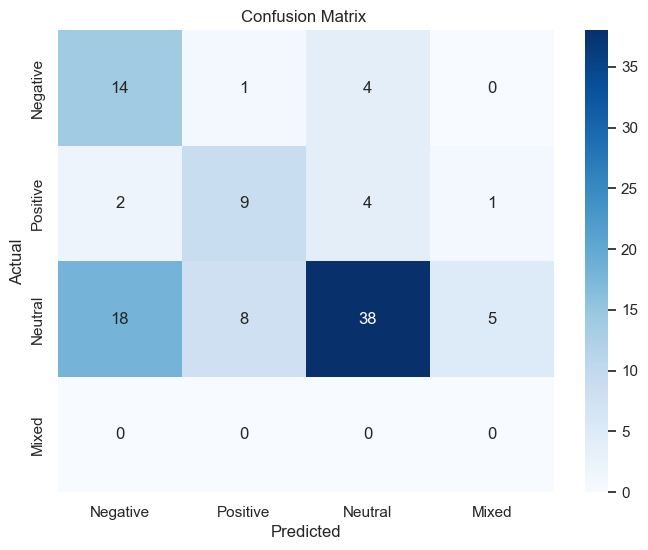

In [21]:
#   Evaluate the mode
accuracy_train = accuracy_score(y_train, model.predict(X_train_cv))
accuracy_val=accuracy_score(y_val,model.predict(X_val_cv))
accuracy_test = accuracy_score(y_test, y_pred)
print(f" Accuracy train: {accuracy_train:.4f}")
print(f" Accuracy val: {accuracy_val:.4f}")
print(f" Accuracy test: {accuracy_test:.4f}")

  # Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))

    # Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral','Mixed'],
                yticklabels=['Negative', 'Positive', 'Neutral','Mixed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()

In [22]:
#Metrics

#Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))


Confusion Matrix:
[[14  1  4  0]
 [ 2  9  4  1]
 [18  8 38  5]
 [ 0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.74      0.53        19
           1       0.50      0.56      0.53        16
           2       0.83      0.55      0.66        69
           3       0.00      0.00      0.00         0

    accuracy                           0.59       104
   macro avg       0.43      0.46      0.43       104
weighted avg       0.70      0.59      0.62       104



**LSTM**

In [23]:
# Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GRU

In [24]:
#Preprocessing
train_texts=df_augmented['processed_text'].tolist()
test_texts=df_test['processed_text'].tolist()
val_texts=df_validation['processed_text'].tolist()

print(train_texts[0])

pale blue berry peaceful shade


In [25]:
#Tokenization

tokenizer=Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences=tokenizer.texts_to_sequences(train_texts)
test_sequences=tokenizer.texts_to_sequences(test_texts)
val_sequences=tokenizer.texts_to_sequences(val_texts)

print(train_sequences[0])

[375, 408, 409, 795, 796]


In [26]:
#calculating max_len

seq_lengths=[len(seq) for seq in train_sequences]
max_len=int(np.percentile(seq_lengths,95))
print("max_len: ",max_len)

max_len:  7


In [27]:
#padding

X_train=pad_sequences(train_sequences,maxlen=max_len,padding='post')
X_test=pad_sequences(test_sequences,maxlen=max_len,padding='post')
X_val=pad_sequences(val_sequences,maxlen=max_len,padding='post')

print("train_sequence_padded",X_train)

train_sequence_padded [[ 375  408  409 ...  796    0    0]
 [ 173   37   75 ...    0    0    0]
 [ 931    6    0 ...    0    0    0]
 ...
 [2787  591  308 ...  592  105  825]
 [1695  591  308 ...  592  105 3021]
 [  42  591  308 ...  592  105 1025]]


In [28]:
#etiquetas

y_train=df_augmented['label'].values
y_test=df_test['label'].values
y_val=df_validation['label'].values

print(y_val)

[2 1 2 0 2 0 1 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 1 1 2 2 2 1 2 2 2 0 2 0 2 2 2 2 0 0 2 2 2 0 1 2 1 1 1 2 2 0 0 1 0
 2 2 2 2 1 0 1 2 2 0 0 2 2 0 2 2 2 0 2 0 2 1 2 1 2 2 2 2 2 1 0]


In [29]:
classes=np.unique(y_train)
print(classes)
cw=compute_class_weight(class_weight='balanced',classes=classes,y=y_train)
class_weights=dict(zip(classes,cw))
print(class_weights)

[0 1 2 3]
{0: 0.6879292403746098, 1: 0.8017220470531167, 2: 1.1911711711711712, 3: 2.176102699144174}


In [30]:
#LSTM model with improvements: Bidirectional, more units, and better regularization
new_var = 128
model = Sequential([
    Embedding(input_dim=10000, output_dim=new_var, input_length=max_len),
    Bidirectional(LSTM(256, activation='tanh', return_sequences=True)),
    Dropout(0.6),
    Bidirectional(LSTM(128, activation='tanh')),
    Dropout(0.6),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

print("Improved LSTM Architecture:")
print("- Bidirectional processing (processes text left-to-right and right-to-left)")
print("- Two LSTM layers: 256 units -> 128 units")
print("- Multiple dense layers: 256 -> 128 -> 4 (output)")
print("- Higher dropout (0.6) to prevent overfitting")


Improved LSTM Architecture:
- Bidirectional processing (processes text left-to-right and right-to-left)
- Two LSTM layers: 256 units -> 128 units
- Multiple dense layers: 256 -> 128 -> 4 (output)
- Higher dropout (0.6) to prevent overfitting


In [31]:
#Training
import keras
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 128)            1280000   
                                                                 
 bidirectional (Bidirection  (None, 7, 512)            788480    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 512)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [32]:
history=model.fit(X_train, y_train, epochs=30, batch_size=16, shuffle=True,validation_data=(X_val, y_val),class_weight=class_weights)


Epoch 1/30
827/827 [==============================] - 26s 26ms/step - loss: 1.3860 - accuracy: 0.2861 - val_loss: 1.3821 - val_accuracy: 0.4000
Epoch 2/30
827/827 [==============================] - 20s 24ms/step - loss: 1.3854 - accuracy: 0.2868 - val_loss: 1.3769 - val_accuracy: 0.6381
Epoch 3/30
827/827 [==============================] - 19s 23ms/step - loss: 1.3835 - accuracy: 0.2913 - val_loss: 1.3666 - val_accuracy: 0.6000
Epoch 4/30
827/827 [==============================] - 19s 23ms/step - loss: 1.3807 - accuracy: 0.2938 - val_loss: 1.3510 - val_accuracy: 0.6000
Epoch 5/30
827/827 [==============================] - 21s 25ms/step - loss: 1.3769 - accuracy: 0.2919 - val_loss: 1.3327 - val_accuracy: 0.6190
Epoch 6/30
827/827 [==============================] - 20s 24ms/step - loss: 1.3660 - accuracy: 0.2938 - val_loss: 1.3032 - val_accuracy: 0.5905
Epoch 7/30
827/827 [==============================] - 20s 24ms/step - loss: 1.3226 - accuracy: 0.3145 - val_loss: 1.2442 - val_accuracy:

4/4 [==============================] - 0s 7ms/step
 Accuracy_test: 0.4135
 Accuracy_train: 0.9523
 Accuracy_val: 0.5810

Classification Report LSTM:
              precision    recall  f1-score   support

           0       0.12      0.21      0.15        19
           1       0.25      0.25      0.25        16
           2       0.66      0.51      0.57        69
           3       0.00      0.00      0.00         0

    accuracy                           0.41       104
   macro avg       0.26      0.24      0.24       104
weighted avg       0.50      0.41      0.45       104

 Accuracy_test: 0.4135
 Accuracy_train: 0.9523
 Accuracy_val: 0.5810

Classification Report LSTM:
              precision    recall  f1-score   support

           0       0.12      0.21      0.15        19
           1       0.25      0.25      0.25        16
           2       0.66      0.51      0.57        69
           3       0.00      0.00      0.00         0

    accuracy                           0.41   

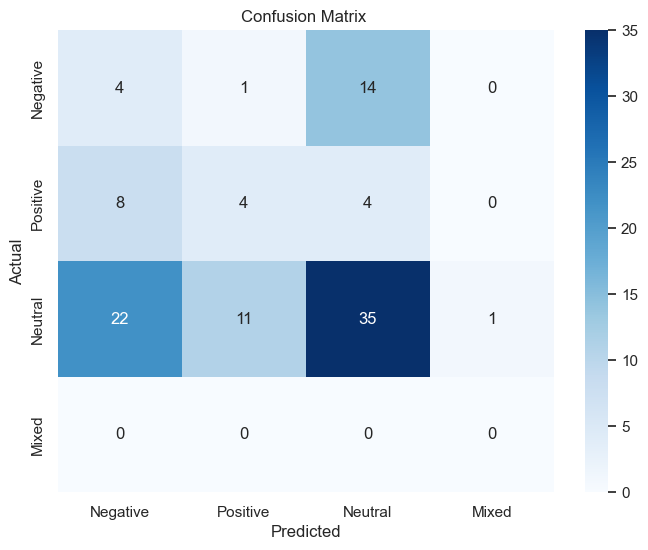

In [33]:
#Confusion matrix

y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

#   Evaluate the mode
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, model.predict(X_train).argmax(axis=1))
accuracy_val = accuracy_score(y_val, model.predict(X_val).argmax(axis=1))
print(f" Accuracy_test: {accuracy_test:.4f}")
print(f" Accuracy_train: {accuracy_train:.4f}")
print(f" Accuracy_val: {accuracy_val:.4f}")

  # Generate classification report
print("\nClassification Report LSTM:")
print(classification_report(y_test, y_pred,zero_division=0))

    # Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral','Mixed'],
                yticklabels=['Negative', 'Positive', 'Neutral','Mixed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()

In [35]:
# Análisis detallado de la clase 1 (Positive)
print("=" * 60)
print("ANÁLISIS DETALLADO DE LA CLASE 1 (POSITIVE)")
print("=" * 60)

# 1. Distribución de clases en test
print("\n1. Distribución de clases en TEST:")
print(f"Total ejemplos en test: {len(y_test)}")
for clase in range(4):
    count = (y_test == clase).sum()
    percentage = (count / len(y_test)) * 100
    sentiments = ['Negative', 'Positive', 'Neutral', 'Mixed']
    print(f"   Clase {clase} ({sentiments[clase]}): {count} ejemplos ({percentage:.1f}%)")

# 2. Distribución de predicciones
print("\n2. Distribución de PREDICCIONES del modelo:")
print(f"Total predicciones: {len(y_pred)}")
for clase in range(4):
    count = (y_pred == clase).sum()
    percentage = (count / len(y_pred)) * 100
    sentiments = ['Negative', 'Positive', 'Neutral', 'Mixed']
    print(f"   Clase {clase} ({sentiments[clase]}): {count} predicciones ({percentage:.1f}%)")

# 3. ¿Cuántos ejemplos de clase 1 fueron predichos correctamente?
print("\n3. Análisis específico de clase 1 (Positive):")
class_1_indices = np.where(y_test == 1)[0]
print(f"   Total ejemplos de clase 1 en test: {len(class_1_indices)}")

if len(class_1_indices) > 0:
    predictions_for_class_1 = y_pred[class_1_indices]
    print(f"   Predicciones para ejemplos de clase 1:")
    for clase in range(4):
        count = (predictions_for_class_1 == clase).sum()
        sentiments = ['Negative', 'Positive', 'Neutral', 'Mixed']
        print(f"      Predichas como clase {clase} ({sentiments[clase]}): {count}")
    
    correct = (predictions_for_class_1 == 1).sum()
    print(f"\n   → Ejemplos de clase 1 predichos CORRECTAMENTE: {correct}")
    print(f"   → Ejemplos de clase 1 predichos INCORRECTAMENTE: {len(class_1_indices) - correct}")

# 4. Matriz de confusión enfocada
print("\n4. Matriz de Confusión (valores numéricos):")
print(cm)


ANÁLISIS DETALLADO DE LA CLASE 1 (POSITIVE)

1. Distribución de clases en TEST:
Total ejemplos en test: 104
   Clase 0 (Negative): 19 ejemplos (18.3%)
   Clase 1 (Positive): 16 ejemplos (15.4%)
   Clase 2 (Neutral): 69 ejemplos (66.3%)
   Clase 3 (Mixed): 0 ejemplos (0.0%)

2. Distribución de PREDICCIONES del modelo:
Total predicciones: 104
   Clase 0 (Negative): 34 predicciones (32.7%)
   Clase 1 (Positive): 16 predicciones (15.4%)
   Clase 2 (Neutral): 53 predicciones (51.0%)
   Clase 3 (Mixed): 1 predicciones (1.0%)

3. Análisis específico de clase 1 (Positive):
   Total ejemplos de clase 1 en test: 16
   Predicciones para ejemplos de clase 1:
      Predichas como clase 0 (Negative): 8
      Predichas como clase 1 (Positive): 4
      Predichas como clase 2 (Neutral): 4
      Predichas como clase 3 (Mixed): 0

   → Ejemplos de clase 1 predichos CORRECTAMENTE: 4
   → Ejemplos de clase 1 predichos INCORRECTAMENTE: 12

4. Matriz de Confusión (valores numéricos):
[[ 4  1 14  0]
 [ 8  4  

In [41]:
# Mostrar ejemplos reales de textos de clase 1
print("\n" + "=" * 60)
print("EJEMPLOS DE TEXTOS DE CLASE 1 (POSITIVE) EN TEST")
print("=" * 60)

# Obtener índices de clase 1 en el dataframe de test
class_1_test_indices = df_test[df_test['label'] == 1].index.tolist()
print(f"\nTotal de ejemplos de clase 1 en test: {len(class_1_test_indices)}")

if len(class_1_test_indices) > 0:
    print("\nPrimeros 5 ejemplos de clase 1 (Positive):")
    for i, idx in enumerate(class_1_test_indices[:5]):
        print(f"\n{i+1}. Texto original:")
        print(f"   '{df_test.loc[idx, 'verse_text']}'")
        print(f"   Texto procesado: '{df_test.loc[idx, 'processed_text']}'")
        
        # Encontrar el índice correspondiente en y_test
        test_position = np.where(y_test == 1)[0]
        if i < len(test_position):
            real_position = test_position[i]
            prediction = y_pred[real_position]
            sentiment_map = {0: 'Negative', 1: 'Positive', 2: 'Neutral', 3: 'Mixed'}
            print(f"   Predicción del modelo: {sentiment_map[prediction]}")
else:
    print("No hay ejemplos de clase 1 en test!")



EJEMPLOS DE TEXTOS DE CLASE 1 (POSITIVE) EN TEST

Total de ejemplos de clase 1 en test: 16

Primeros 5 ejemplos de clase 1 (Positive):

1. Texto original:
   'and be glad in the summer morning when the kindred ride on their way;'
   Texto procesado: 'glad summer morning kindred ride way'
   Predicción del modelo: Neutral

2. Texto original:
   'on thine own bird the sweet enthusiasm'
   Texto procesado: 'thine bird sweet enthusiasm'
   Predicción del modelo: Neutral

3. Texto original:
   'lo now, o daughter of kings, let us rise in the face of the day,'
   Texto procesado: 'lo daughter king let u rise face day'
   Predicción del modelo: Mixed

4. Texto original:
   'how hearts were answering to his own,'
   Texto procesado: 'heart answering'
   Predicción del modelo: Neutral

5. Texto original:
   'may george, beloved by all the nations round,'
   Texto procesado: 'may george beloved nation round'
   Predicción del modelo: Neutral


In [42]:
# Análisis de probabilidades predichas
print("\n" + "=" * 60)
print("ANÁLISIS DE PROBABILIDADES PREDICHAS PARA CLASE 1")
print("=" * 60)

# Obtener índices donde y_test == 1 (clase Positive)
class_1_mask = (y_test == 1)
class_1_count = class_1_mask.sum()

print(f"\nTotal ejemplos de clase 1 en test: {class_1_count}")

if class_1_count > 0:
    # Obtener las probabilidades para los ejemplos de clase 1
    probs_for_class_1 = y_pred_prob[class_1_mask]  # shape: (n_samples, 4)
    
    print(f"\nProbabilidades predichas para ejemplos de clase 1:")
    print(f"Min probabilidad de clase 1: {probs_for_class_1[:, 1].min():.4f}")
    print(f"Max probabilidad de clase 1: {probs_for_class_1[:, 1].max():.4f}")
    print(f"Mean probabilidad de clase 1: {probs_for_class_1[:, 1].mean():.4f}")
    
    print(f"\nClase predicha con mayor probabilidad (para ejemplos clase 1):")
    predictions_for_class_1 = y_pred[class_1_mask]
    for clase in range(4):
        count = (predictions_for_class_1 == clase).sum()
        sentiments = ['Negative', 'Positive', 'Neutral', 'Mixed']
        print(f"   {sentiments[clase]} (clase {clase}): {count} veces")
    
    # Mostrar distribución de probabilidades máximas
    max_probs = probs_for_class_1.max(axis=1)
    print(f"\nProbabilidad máxima predicha (para cualquier clase):")
    print(f"   Min: {max_probs.min():.4f}")
    print(f"   Max: {max_probs.max():.4f}")
    print(f"   Mean: {max_probs.mean():.4f}")
    print(f"   Median: {np.median(max_probs):.4f}")



ANÁLISIS DE PROBABILIDADES PREDICHAS PARA CLASE 1

Total ejemplos de clase 1 en test: 16

Probabilidades predichas para ejemplos de clase 1:
Min probabilidad de clase 1: 0.1325
Max probabilidad de clase 1: 0.2963
Mean probabilidad de clase 1: 0.2459

Clase predicha con mayor probabilidad (para ejemplos clase 1):
   Negative (clase 0): 2 veces
   Positive (clase 1): 0 veces
   Neutral (clase 2): 10 veces
   Mixed (clase 3): 4 veces

Probabilidad máxima predicha (para cualquier clase):
   Min: 0.2639
   Max: 0.6500
   Mean: 0.4414
   Median: 0.4354


In [34]:
misclassified_indices = np.where(y_pred !=y_test)[0]
misclassified_examples = pd.DataFrame({
    'text': df_test.iloc[misclassified_indices]['processed_text'].values,
    'true_sentiment': y_test[misclassified_indices],
    'predicted_sentiment': y_pred[misclassified_indices]
})

print("\nSample of misclassified examples:")
display(misclassified_examples.head(20))


Sample of misclassified examples:


,text,true_sentiment,predicted_sentiment
0,glad summer morning kindred ride way,1,2
1,indignantly hurled cry,0,2
2,house haunted,0,2
3,thine bird sweet enthusiasm,1,2
4,day thou even thou didst know,2,3
5,must change heavn mournful gloom,0,2
6,lo daughter king let u rise face day,1,3
7,penance saintly styrian monk,2,0
8,heart answering,1,2
9,glad stonebuilt hearth thorough widemouthed sm...,2,3


**Logistic regression**

In [35]:

#logistic regression

Vectorizer1=CountVectorizer(max_features=10000)
X_train_cv1=Vectorizer1.fit_transform(df_augmented['processed_text'])

print("Original X_train: ",X_train_cv1.shape)
print("Original y_train: ",y_train.shape)

X_test_cv1=Vectorizer1.transform(df_test['processed_text'])
X_val_cv1=Vectorizer1.transform(df_validation['processed_text'])


Original X_train:  (7830, 4974)
Original y_train:  (7830,)


In [ ]:
model3=LogisticRegression(max_iter=1000,class_weight='balanced')
model3.fit(X_train_cv1,y_train)
y_pred=model3.predict(X_test_cv1)
print("Prediction: ",y_pred)
print("Real: ", y_test)
print("Accuracy_train: ",model3.score(X_train_cv1,y_train))
print("Accuracy_test: ",model3.score(X_test_cv1,y_test))
print("Accuracy_val: ",model3.score(X_val_cv1,y_val))

Prediction:  [2 1 2 2 2 0 2 2 2 2 1 1 2 2 3 2 2 2 2 2 0 1 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2
 2 2 2 3 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Real:  [2 1 2 2 2 0 0 2 2 2 1 2 2 2 2 0 1 2 2 2 2 1 2 2 0 0 2 2 0 0 1 2 2 2 1 0 2
 2 2 1 2 2 2 1 2 2 2 0 0 0 1 2 0 2 0 2 2 2 2 2 2 1 1 2 0 2 2 2 0 2 1 2 2 1
 2 2 2 1 2 2 0 2 2 2 0 2 2 2 0 2 2 2 0 2 1 1 2 2 2 2 2 2 2 2]
Accuracy_train:  0.9985951468710089
Accuracy_test:  0.6923076923076923
Accuracy_val:  0.6571428571428571


Confusion Matrix:
[[ 3  0 15  1]
 [ 2  0 10  4]
 [ 4  1 54 10]
 [ 0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.16      0.21        19
           1       0.00      0.00      0.00        16
           2       0.68      0.78      0.73        69
           3       0.00      0.00      0.00         0

    accuracy                           0.55       104
   macro avg       0.25      0.24      0.24       104
weighted avg       0.51      0.55      0.52       104



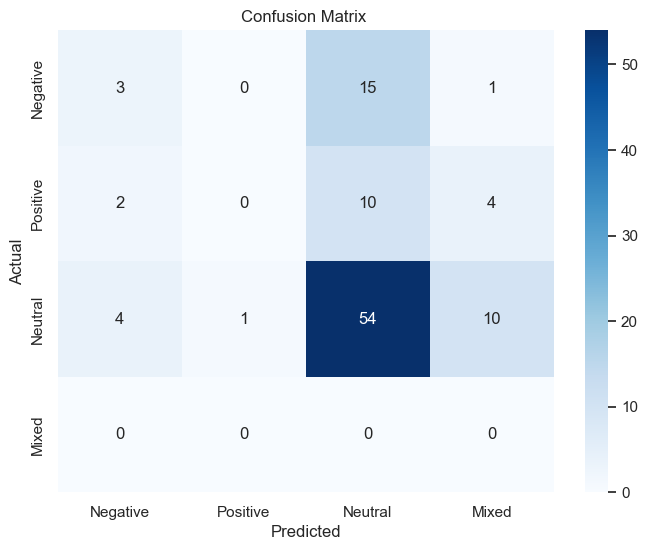

In [38]:
#Confusion matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral','Mixed'],
                yticklabels=['Negative', 'Positive', 'Neutral','Mixed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()